In [4]:
%pip install torch torchvision torchaudio torch-geometric
%pip install networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 801.1 kB/s eta 0:00:00 0:00:01
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.9/467.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -

Processing...
Done!


--- Training GCN with 1 layer(s) ---
Final Test Accuracy for 1 layers: 0.8020

--- Training GCN with 2 layer(s) ---
Final Test Accuracy for 2 layers: 0.7950

--- Training GCN with 3 layer(s) ---
Final Test Accuracy for 3 layers: 0.8130

--- Training GCN with 5 layer(s) ---
Final Test Accuracy for 5 layers: 0.7810

--- Training GCN with 8 layer(s) ---
Final Test Accuracy for 8 layers: 0.7110

--- Training GCN with 10 layer(s) ---
Final Test Accuracy for 10 layers: 0.3580



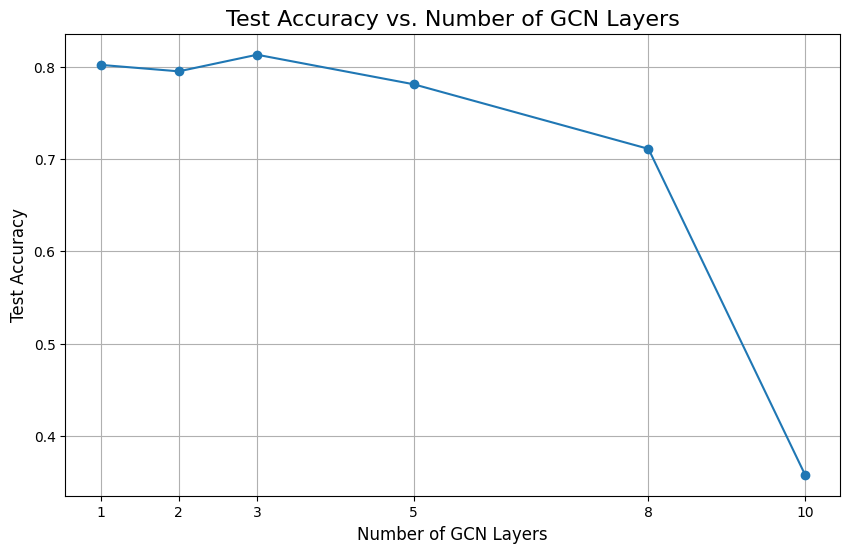

In [5]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT VÀ IMPORT THƯ VIỆN (Giống như code gốc)
# ==============================================================================


import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# ==============================================================================
# BƯỚC 2: TẢI VÀ CHUẨN BỊ DỮ LIỆU (Giống như code gốc)
# ==============================================================================
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# ==============================================================================
# BƯỚC 3: THIẾT KẾ MÔ HÌNH GCN LINH HOẠT VỚI SỐ LỚP TÙY CHỈNH
# ==============================================================================
class GCN(torch.nn.Module):
    def __init__(self, num_layers, hidden_dim, input_dim, output_dim):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        # Lớp đầu tiên
        self.layers.append(GCNConv(input_dim, hidden_dim))
        # Các lớp ẩn (nếu có)
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))
        # Lớp cuối cùng
        self.layers.append(GCNConv(hidden_dim, output_dim))
        # Dropout để chống học vẹt
        self.dropout = 0.5

    def forward(self, x, edge_index):
        # Duyệt qua các lớp, trừ lớp cuối
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        # Lớp cuối không có ReLU và Dropout
        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# ==============================================================================
# BƯỚC 4: VIẾT HÀM HUẤN LUYỆN VÀ ĐÁNH GIÁ
# ==============================================================================
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Dùng decorator @torch.no_grad() để không tính gradient khi đánh giá
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    # Tính accuracy trên cả 3 tập: train, validation, test
    train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    train_acc = int(train_correct) / int(data.train_mask.sum())
    
    val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = int(val_correct) / int(data.val_mask.sum())

    test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_acc = int(test_correct) / int(data.test_mask.sum())
    
    return train_acc, val_acc, test_acc

# ==============================================================================
# BƯỚC 5: CHẠY THÍ NGHIỆM VỚI CÁC CẤU HÌNH KHÁC NHAU
# ==============================================================================
layer_configs = [1, 2, 3, 5, 8, 10] # Các số lớp GCN chúng ta sẽ thử
results = []

for num_layers in layer_configs:
    print(f"--- Training GCN with {num_layers} layer(s) ---")
    
    model = GCN(
        num_layers=num_layers, 
        hidden_dim=16, 
        input_dim=dataset.num_node_features,
        output_dim=dataset.num_classes
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    best_val_acc = 0
    final_test_acc = 0
    
    for epoch in range(1, 201):
        train(model, optimizer, data)
        # Đánh giá trên tập validation ở mỗi epoch để tìm model tốt nhất
        _, val_acc, test_acc = evaluate(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc
    
    results.append(final_test_acc)
    print(f"Final Test Accuracy for {num_layers} layers: {final_test_acc:.4f}\n")


# ==============================================================================
# BƯỚC 6: TRỰC QUAN HÓA VÀ PHÂN TÍCH KẾT QUẢ
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(layer_configs, results, marker='o', linestyle='-')
plt.title('Test Accuracy vs. Number of GCN Layers', fontsize=16)
plt.xlabel('Number of GCN Layers', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.grid(True)
plt.xticks(layer_configs)
plt.show()

--- Loading and training on dataset: Cora ---
Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
Average degree: 3.90
Final Test Accuracy for Cora: 0.7970

--- Loading and training on dataset: CiteSeer ---


Processing...
Done!


Number of nodes: 3327
Number of edges: 9104
Number of classes: 6
Average degree: 2.74
Final Test Accuracy for CiteSeer: 0.6810

--- Loading and training on dataset: PubMed ---


Processing...
Done!


Number of nodes: 19717
Number of edges: 88648
Number of classes: 3
Average degree: 4.50
Final Test Accuracy for PubMed: 0.7820



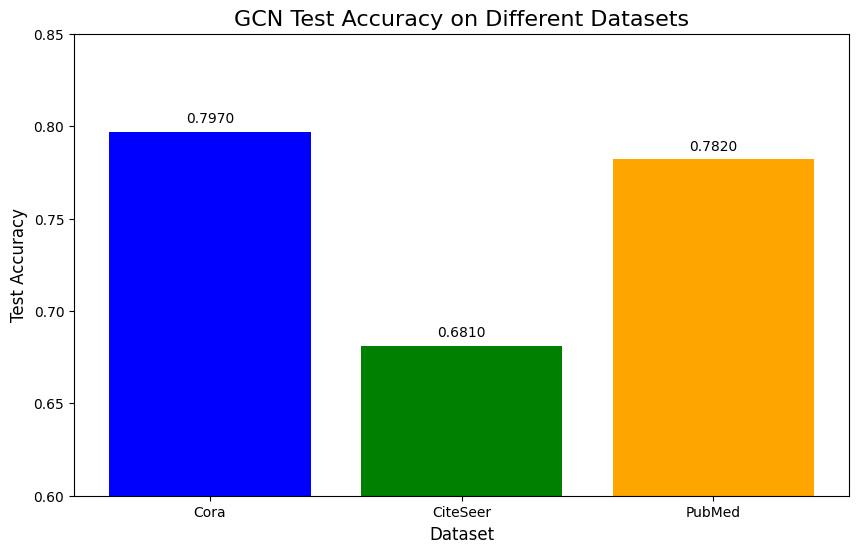

In [6]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT VÀ IMPORT THƯ VIỆN
# ==============================================================================
# !pip install torch torchvision torchaudio torch-geometric
# !pip install networkx matplotlib

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# ==============================================================================
# BƯỚC 2: TÁI SỬ DỤNG CÁC HÀM TỪ BÀI TRƯỚC
# ==============================================================================

# Định nghĩa kiến trúc mô hình GCN (giữ nguyên)
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = 0.5

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Hàm huấn luyện (giữ nguyên)
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Hàm đánh giá (giữ nguyên)
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_acc = int(test_correct) / int(data.test_mask.sum())
    return test_acc

# ==============================================================================
# BƯỚC 3: CHẠY THÍ NGHIỆM TRÊN TỪNG BỘ DỮ LIỆU
# ==============================================================================

dataset_names = ['Cora', 'CiteSeer', 'PubMed']
results = {}

for name in dataset_names:
    print(f"--- Loading and training on dataset: {name} ---")
    
    # Tải bộ dữ liệu tương ứng
    dataset = Planetoid(root=f'/tmp/{name}', name=name)
    data = dataset[0]
    
    # In ra thông tin để so sánh
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Number of classes: {dataset.num_classes}")
    print(f"Average degree: {data.num_edges / data.num_nodes:.2f}")

    # Khởi tạo mô hình và optimizer
    # Sử dụng kiến trúc GCN 2 lớp tiêu chuẩn
    model = GCN(
        input_dim=dataset.num_node_features,
        hidden_dim=16,
        output_dim=dataset.num_classes
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    best_val_acc = 0
    final_test_acc = 0
    
    # Huấn luyện mô hình
    for epoch in range(1, 201):
        train(model, optimizer, data)
        # Chúng ta sẽ đơn giản hóa bằng cách lấy kết quả ở epoch cuối cùng
        # (Trong thực tế, bạn sẽ dùng tập validation để chọn epoch tốt nhất)
    
    final_test_acc = evaluate(model, data)
    results[name] = final_test_acc
    
    print(f"Final Test Accuracy for {name}: {final_test_acc:.4f}\n")

# ==============================================================================
# BƯỚC 4: TRỰC QUAN HÓA VÀ PHÂN TÍCH KẾT QUẢ
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange'])
plt.title('GCN Test Accuracy on Different Datasets', fontsize=16)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
# Thiết lập giới hạn trục y để dễ so sánh
plt.ylim(0.6, 0.85) 
for i, (name, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha='center')
plt.show()

Bag-of-Words feature matrix shape: torch.Size([2708, 1433])
Degree-based feature matrix shape: torch.Size([2708, 1])
--- Running Experiment 1: Using Bag-of-Words Features ---
Accuracy with Bag-of-Words features: 0.8030

--- Running Experiment 2: Using only Node Degree Features ---
Accuracy with only Node Degree features: 0.2080



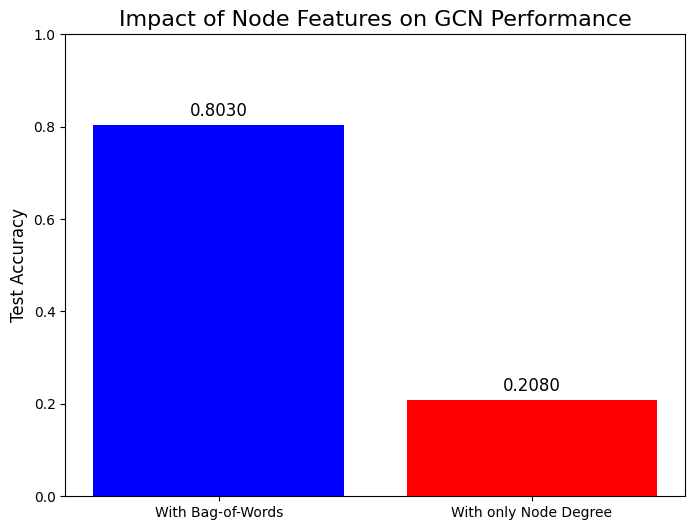

In [7]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT VÀ IMPORT THƯ VIỆN
# ==============================================================================
# !pip install torch torchvision torchaudio torch-geometric
# !pip install networkx matplotlib scikit-learn

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import degree
import matplotlib.pyplot as plt

# ==============================================================================
# BƯỚC 2: TẢI DỮ LIỆU
# ==============================================================================
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# ==============================================================================
# BƯỚC 3: TẠO CÁC BỘ ĐẶC TRƯNG KHÁC NHAU
# ==============================================================================

# 1. Đặc trưng Bag-of-Words (có sẵn)
features_bow = data.x
print(f"Bag-of-Words feature matrix shape: {features_bow.shape}")

# 2. Tạo đặc trưng CHỈ DÙNG CẤU TRÚC: Bậc của nút (Node Degree)
# Tính bậc của mỗi nút
deg = degree(data.edge_index[0], dtype=torch.float)
# Chuẩn hóa bậc (một bước quan trọng)
deg = (deg - deg.mean()) / deg.std()
# Chuyển thành ma trận đặc trưng (N x 1)
features_degree = deg.unsqueeze(1)
print(f"Degree-based feature matrix shape: {features_degree.shape}")

# ==============================================================================
# BƯỚC 4: XÂY DỰNG HÀM HUẤN LUYỆN VÀ ĐÁNH GIÁ CHUNG
# ==============================================================================

# Dùng lại kiến trúc GCN 2 lớp
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Hàm huấn luyện và đánh giá một mô hình hoàn chỉnh
def run_experiment(model, features, data):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # Huấn luyện
    for epoch in range(1, 201):
        model.train()
        optimizer.zero_grad()
        out = model(features, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
    # Đánh giá
    model.eval()
    pred = model(features, data.edge_index).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

# ==============================================================================
# BƯỚC 5: CHẠY CẢ HAI THÍ NGHIỆM
# ==============================================================================
results = {}

# Thí nghiệm 1: Dùng Bag-of-Words (Domain Knowledge)
print("--- Running Experiment 1: Using Bag-of-Words Features ---")
model_bow = GCN(
    input_dim=features_bow.shape[1], 
    hidden_dim=16, 
    output_dim=dataset.num_classes
)
acc_bow = run_experiment(model_bow, features_bow, data)
results['With Bag-of-Words'] = acc_bow
print(f"Accuracy with Bag-of-Words features: {acc_bow:.4f}\n")


# Thí nghiệm 2: Chỉ dùng Bậc của nút (Structural Knowledge)
print("--- Running Experiment 2: Using only Node Degree Features ---")
model_degree = GCN(
    input_dim=features_degree.shape[1], 
    hidden_dim=16, 
    output_dim=dataset.num_classes
)
acc_degree = run_experiment(model_degree, features_degree, data)
results['With only Node Degree'] = acc_degree
print(f"Accuracy with only Node Degree features: {acc_degree:.4f}\n")

# ==============================================================================
# BƯỚC 6: TRỰC QUAN HÓA VÀ KẾT LUẬN
# ==============================================================================
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'red'])
plt.title('Impact of Node Features on GCN Performance', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1.0)
for i, (name, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)
plt.show()

In [8]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT VÀ IMPORT THƯ VIỆN
# ==============================================================================
# !pip install torch torchvision torchaudio torch-geometric

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool

# ==============================================================================
# BƯỚC 2: TẢI VÀ CHUẨN BỊ DỮ LIỆU MUTAG
# ==============================================================================
# Tải bộ dữ liệu MUTAG
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# In ra thông tin để hiểu về bộ dữ liệu
print(f"Dataset: {dataset.name}")
print(f"Number of graphs: {len(dataset)}") # MUTAG là một tập hợp của nhiều đồ thị
print(f"Number of node features: {dataset.num_node_features}")
print(f"Number of classes: {dataset.num_classes}") # 2 lớp: gây đột biến hoặc không

# Xáo trộn dữ liệu để đảm bảo tính ngẫu nhiên
torch.manual_seed(42)
dataset = dataset.shuffle()

# Chia dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%)
train_dataset = dataset[:int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8):]

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

# Tạo DataLoaders để xử lý các batch đồ thị
# Khác với bài trước (1 đồ thị lớn), ở đây ta có nhiều đồ thị nhỏ
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==============================================================================
# BƯỚC 3: XÂY DỰNG MÔ HÌNH GIN
# ==============================================================================
class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        # GINConv yêu cầu một mạng MLP nhỏ bên trong nó.
        # Đây là phần cốt lõi làm cho GIN trở nên mạnh mẽ.
        mlp1 = Sequential(Linear(input_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(mlp1)
        
        mlp2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(mlp2)
        
        # Một lớp tuyến tính cuối cùng để phân loại toàn bộ đồ thị
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # 1. Thu được biểu diễn của các nút (Node Embeddings)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # 2. Bước quan trọng: Gộp tất cả các biểu diễn nút thành một biểu diễn duy nhất cho toàn bộ đồ thị
        # global_add_pool sẽ cộng tất cả các vector nút trong cùng một đồ thị lại với nhau.
        x = global_add_pool(x, batch)
        
        # 3. Đưa qua lớp phân loại cuối cùng
        x = self.fc(x)
        
        # Ở đây ta không cần softmax vì CrossEntropyLoss sẽ tự làm điều đó
        return x

# ==============================================================================
# BƯỚC 4: VIẾT HÀM HUẤN LUYỆN VÀ ĐÁNH GIÁ
# ==============================================================================
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader: # Lặp qua các batch đồ thị
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# ==============================================================================
# BƯỚC 5: CHẠY THÍ NGHIỆM
# ==============================================================================
model = GIN(
    input_dim=dataset.num_node_features,
    hidden_dim=32,
    output_dim=dataset.num_classes
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

print("\n--- Starting Training ---")
for epoch in range(1, 101):
    loss = train(model, train_loader, optimizer, criterion)
    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)
    
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print("\n--- Final Evaluation ---")
final_train_acc = evaluate(model, train_loader)
final_test_acc = evaluate(model, test_loader)
print(f'Final Train Accuracy: {final_train_acc:.4f}')
print(f'Final Test Accuracy: {final_test_acc:.4f}')

Processing...
Done!


Dataset: MUTAG
Number of graphs: 188
Number of node features: 7
Number of classes: 2
Number of training graphs: 150
Number of test graphs: 38

--- Starting Training ---
Epoch: 020, Loss: 0.4996, Train Acc: 0.7667, Test Acc: 0.6053
Epoch: 040, Loss: 0.4145, Train Acc: 0.7933, Test Acc: 0.6316
Epoch: 060, Loss: 0.3730, Train Acc: 0.8400, Test Acc: 0.7105
Epoch: 080, Loss: 0.3543, Train Acc: 0.8267, Test Acc: 0.7368
Epoch: 100, Loss: 0.3493, Train Acc: 0.8400, Test Acc: 0.7368

--- Final Evaluation ---
Final Train Accuracy: 0.8400
Final Test Accuracy: 0.7368


--- Running Experiment: Baseline (No Noise) ---
Final Test Accuracy: 0.7980

--- Running Experiment: Edge Dropout (20%) ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


Final Test Accuracy: 0.7950

--- Running Experiment: Label Noise (20%) ---
Final Test Accuracy: 0.7880



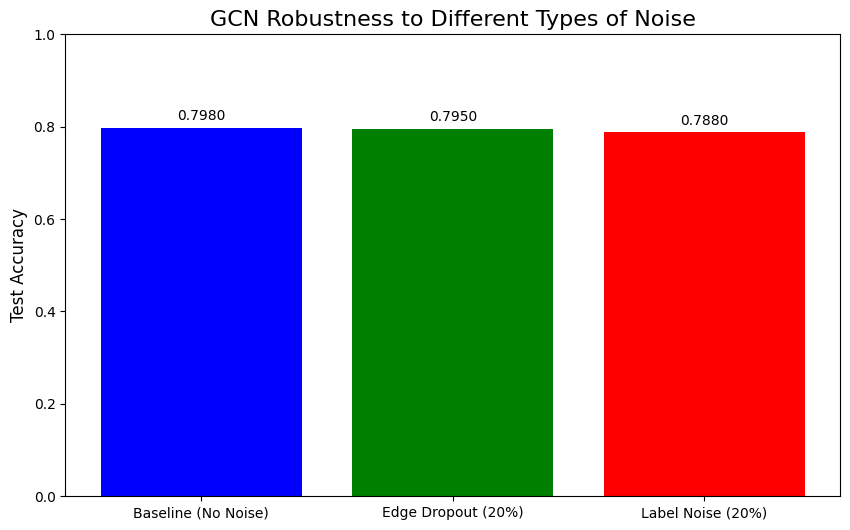

In [9]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT VÀ IMPORT THƯ VIỆN
# ==============================================================================
# !pip install torch torchvision torchaudio torch-geometric
# !pip install networkx matplotlib

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dropout_adj
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# BƯỚC 2: TẢI DỮ LIỆU
# ==============================================================================
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# ==============================================================================
# BƯỚC 3: XÂY DỰNG MÔ HÌNH VÀ CÁC HÀM TIỆN ÍCH
# ==============================================================================
# Dùng lại kiến trúc GCN 2 lớp
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Hàm đánh giá (giữ nguyên)
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    # Luôn đánh giá trên đồ thị gốc, không nhiễu
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_acc = int(test_correct) / int(data.test_mask.sum())
    return test_acc

# ==============================================================================
# BƯỚC 4: TRIỂN KHAI CÁC PHIÊN BẢN HUẤN LUYỆN CÓ NHIỄU
# ==============================================================================

# 1. Hàm huấn luyện gốc (không nhiễu)
def train_baseline(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# 2. Hàm huấn luyện với Edge Dropout
def train_edge_dropout(model, optimizer, data, p=0.2):
    model.train()
    optimizer.zero_grad()
    # Tạo một phiên bản đồ thị bị làm rớt cạnh ngẫu nhiên
    edge_index_dropped, _ = dropout_adj(data.edge_index, p=p, training=model.training)
    out = model(data.x, edge_index_dropped)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# 3. Hàm huấn luyện với Label Noise
def train_label_noise(model, optimizer, data, noise_rate=0.2):
    model.train()
    optimizer.zero_grad()
    
    # Tạo một bản sao của các nhãn để thêm nhiễu
    y_noisy = data.y.clone()
    # Chỉ thêm nhiễu vào các nút trong tập train
    train_labels = y_noisy[data.train_mask]
    
    # Chọn ngẫu nhiên một số nhãn trong tập train để lật
    n_train = len(train_labels)
    n_to_flip = int(n_train * noise_rate)
    indices_to_flip = np.random.choice(np.arange(n_train), size=n_to_flip, replace=False)
    
    # Lật các nhãn đã chọn sang một lớp ngẫu nhiên khác
    for i in indices_to_flip:
        current_label = train_labels[i]
        new_label = np.random.choice([l for l in range(dataset.num_classes) if l != current_label])
        train_labels[i] = new_label
        
    y_noisy[data.train_mask] = train_labels
    
    # Huấn luyện mô hình trên các nhãn bị nhiễu
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], y_noisy[data.train_mask])
    loss.backward()
    optimizer.step()

# ==============================================================================
# BƯỚC 5: CHẠY CÁC THÍ NGHIỆM VÀ SO SÁNH
# ==============================================================================
results = {}

# Chạy từng thí nghiệm
experiments = {
    "Baseline (No Noise)": train_baseline,
    "Edge Dropout (20%)": lambda m, o, d: train_edge_dropout(m, o, d, p=0.2),
    "Label Noise (20%)": lambda m, o, d: train_label_noise(m, o, d, noise_rate=0.2)
}

for name, train_func in experiments.items():
    print(f"--- Running Experiment: {name} ---")
    model = GCN(
        input_dim=dataset.num_node_features,
        hidden_dim=16,
        output_dim=dataset.num_classes
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(1, 201):
        train_func(model, optimizer, data)
        
    acc = evaluate(model, data)
    results[name] = acc
    print(f"Final Test Accuracy: {acc:.4f}\n")

# ==============================================================================
# BƯỚC 6: TRỰC QUAN HÓA KẾT QUẢ
# ==============================================================================
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red'])
plt.title('GCN Robustness to Different Types of Noise', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1.0)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom')
plt.show()